In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import lfp_pre_processing_functions



In [ ]:
def base_signal_generation(baseline_time_sec, epoch_time_sec, number_of_epoch, fs):
    # Ensure signal length accommodates complete epochs
    signal_len = int(fs * baseline_time_sec + number_of_epoch * epoch_time_sec * fs)
    base_signal = np.random.randn(signal_len)
    #base_signal = np.zeros(signal_len)
    epoch_starts = np.arange(int(baseline_time_sec*fs), signal_len, int(fs*epoch_time_sec))
    time = np.arange(0, signal_len) / fs  # More precise time array
    return base_signal, time, epoch_starts

def generate_sin_wave(sin_start_time, sin_end_time, frequency_list, amplitude, fs, theta):
    time = np.arange(sin_start_time, sin_end_time, 1/fs)
    sin_combined = np.zeros_like(time)
    for freq in frequency_list:
        sinewave = amplitude * np.sin(2 * np.pi * freq * time + theta)
        sin_combined = sin_combined + sinewave
    return sin_combined

def add_sin_to_base_signal(baseline_time_sec, epoch_time_sec, number_of_epoch, fs, sin_start_time, sin_end_time, frequency_list, amplitude, theta):
    base_signal, time, epoch_starts = base_signal_generation(baseline_time_sec, epoch_time_sec, number_of_epoch, fs)
    sine_wave = generate_sin_wave(sin_start_time, sin_end_time, frequency_list, amplitude, fs ,theta)
    
    for epochi, epoch_start_index in enumerate(epoch_starts):
            sin_start_index = epoch_start_index + int(fs*sin_start_time)
            sin_end_index = sin_start_index + int(fs*(sin_end_time-sin_start_time)) + 1
            
            base_signal[sin_start_index:sin_end_index] = base_signal[sin_start_index:sin_end_index] + sine_wave
    return base_signal, time, epoch_starts

18000 [0.0000e+00 5.0000e-04 1.0000e-03 ... 8.9985e+00 8.9990e+00 8.9995e+00] [ 4000  5400  6800  8200  9600 11000 12400 13800 15200 16600]
[ 9.31226752e-15  1.56434465e-01  3.09016994e-01  4.53990500e-01
  5.87785252e-01  7.07106781e-01  8.09016994e-01  8.91006524e-01
  9.51056516e-01  9.87688341e-01  1.00000000e+00  9.87688341e-01
  9.51056516e-01  8.91006524e-01  8.09016994e-01  7.07106781e-01
  5.87785252e-01  4.53990500e-01  3.09016994e-01  1.56434465e-01
 -1.27425165e-14 -1.56434465e-01 -3.09016994e-01 -4.53990500e-01
 -5.87785252e-01 -7.07106781e-01 -8.09016994e-01 -8.91006524e-01
 -9.51056516e-01 -9.87688341e-01 -1.00000000e+00 -9.87688341e-01
 -9.51056516e-01 -8.91006524e-01 -8.09016994e-01 -7.07106781e-01
 -5.87785252e-01 -4.53990500e-01 -3.09016994e-01 -1.56434465e-01
  1.96191080e-15  1.56434465e-01  3.09016994e-01  4.53990500e-01
  5.87785252e-01  7.07106781e-01  8.09016994e-01  8.91006524e-01
  9.51056516e-01  9.87688341e-01  1.00000000e+00  9.87688341e-01
  9.51056516e-0

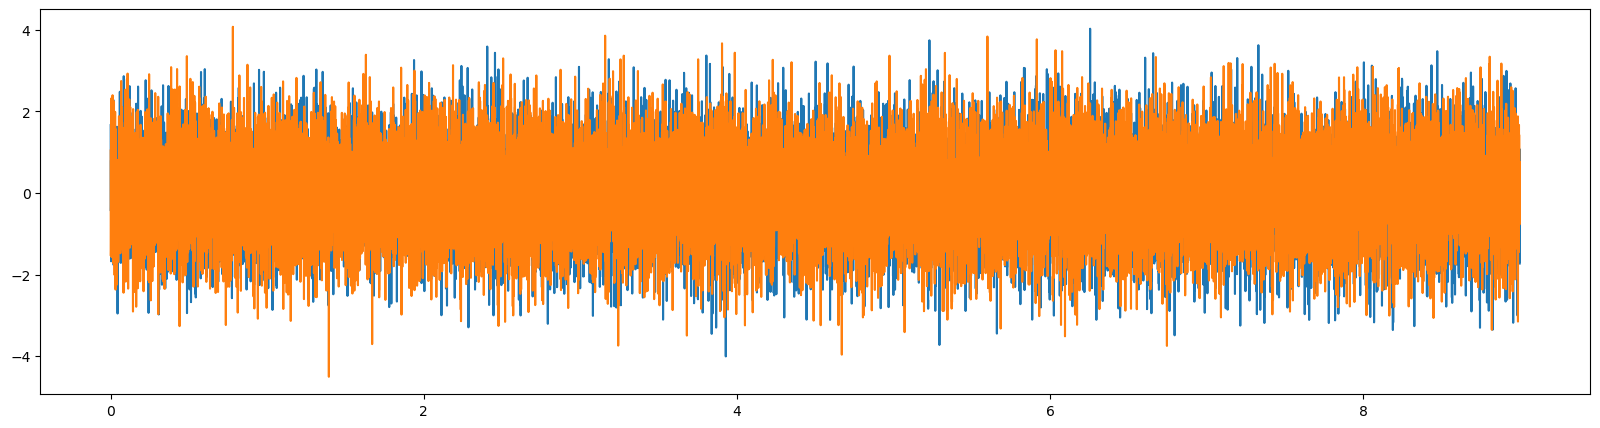

In [3]:
aon_1, time, epoch_starts = add_sin_to_base_signal(baseline_time_sec =2 , epoch_time_sec=0.7, number_of_epoch=10, fs=2000, sin_start_time=0.4, sin_end_time=0.5, frequency_list=[40], amplitude=1, theta=0)

vhp_1, time, epoch_starts = add_sin_to_base_signal(baseline_time_sec =2 , epoch_time_sec=0.7, number_of_epoch=10, fs=2000, sin_start_time=0.5, sin_end_time=0.6, frequency_list=[40], amplitude=1, theta=0)

channel_dict ={"AON_1" : aon_1, "vHp_1" : vhp_1}

fig, ax = plt.subplots(1,1, figsize= (20,5))
ax.plot(time, aon_1, label = "AON")
ax.plot(time, vhp_1, label="VhP")
plt.show()

## Data pre-processing (ref subtraction, padding, baseline subtraction, notch filter)

## MNE epoch generation

In [7]:
import mne
def  generate_mne_epoch(baseline_time_sec,number_of_epoch, epoch_time_sec, epoch_starts,channel_dict,fs ):

    channel_names = list(channel_dict.keys())
    print(channel_names)
    number_of_channel = len(channel_names)
    mne_epoch_blank =np.zeros((number_of_epoch,number_of_channel,int(epoch_time_sec*fs)))
    len_epoch = int(epoch_time_sec*fs)

    for channeli, channel_data in enumerate(channel_dict.values()):
        
        notch_filtered_data = lfp_pre_processing_functions.iir_notch(channel_data, fs=2000, frequency=60)        
        
        data_before, time_data, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, time=time, first_event = baseline_time_sec, sampling_rate = fs)


        for epochi, epoch_start_index in enumerate(epoch_starts):
            epoch_end_index = epoch_start_index + len_epoch
            print(epochi, epoch_start_index, epoch_end_index)
            
            epoch_data = channel_data[epoch_start_index:epoch_end_index]
            epoch_data = lfp_pre_processing_functions.zscore_event_data(epoch_data, baseline_std)

            mne_epoch_blank[epochi, channeli, :] = channel_data[epoch_start_index:epoch_end_index]


    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    mne_epoch_erp = mne.EpochsArray(mne_epoch_blank, info)
    return mne_epoch_erp


mne_epoch_erp = generate_mne_epoch(baseline_time_sec=2,number_of_epoch=10, epoch_time_sec =0.7 , epoch_starts = epoch_starts,channel_dict = channel_dict,fs = 2000)
print(mne_epoch_erp)



['AON_1', 'vHp_1']
notch filter applied
normalizing data
0 4000 5400
1 5400 6800
2 6800 8200
3 8200 9600
4 9600 11000
5 11000 12400
6 12400 13800
7 13800 15200
8 15200 16600
9 16600 18000
notch filter applied
normalizing data
0 4000 5400
1 5400 6800
2 6800 8200
3 8200 9600
4 9600 11000
5 11000 12400
6 12400 13800
7 13800 15200
8 15200 16600
9 16600 18000
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 10 events (all good), 0 – 0.7 s (baseline off), ~226 kB, data loaded,
 '1': 10>


## Power Analysis

In [8]:

def get_power_tfr(epoch):
    fmin=2.5
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False
        
    )

    return power


<EpochsArray | 10 events (all good), 0 – 0.7 s (baseline off), ~116 kB, data loaded,
 '1': 10>
<Power Estimates from Epochs, morlet method | 10 epochs × 1 channels × 98 freqs × 1400 times, 2.5 - 99.5 Hz, 0.00 - 0.70 s, 10.5 MB>
No baseline correction applied


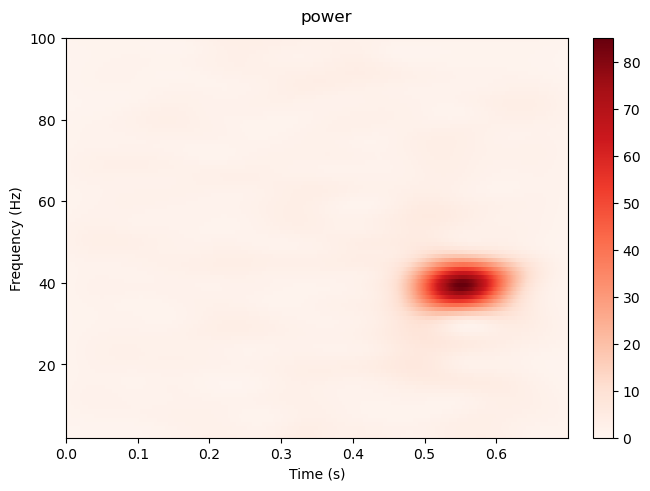

In [9]:
aon1epoch = mne_epoch_erp.copy()
aon1epoch = aon1epoch.pick("vHp_1")
print(aon1epoch)
aon_1_power = get_power_tfr(aon1epoch.pick("vHp_1"))
print(aon_1_power)
averaged_epoch_power = aon_1_power.average(dim='epochs')
averaged_epoch_power.plot(title="power", combine='mean', vlim = (0, None))
mean = np.mean(averaged_epoch_power.get_data(), axis=0)

## Coherence Analysis

C:\Users\CPLab\AppData\Local\Temp\ipykernel_16984\2082932334.py:9: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 0.7 s (baseline off), ~226 kB, data loaded,
 '1': 10>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_erp, method='coh', sfreq=int(fs),
C:\Users\CPLab\AppData\Local\Temp\ipykernel_16984\2082932334.py:9: RuntimeWarning: fmin=1.000 Hz corresponds to 0.700 < 5 cycles based on the epoch length 0.700 sec, need at least 5.000 sec epochs or fmin=7.143. Spectrum estimate will be unreliable.
  con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_erp, method='coh', sfreq=int(fs),
c:\Users\CPLab\anaconda3\envs\lfp\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\CPLab\anaconda3\envs\lfp\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divid

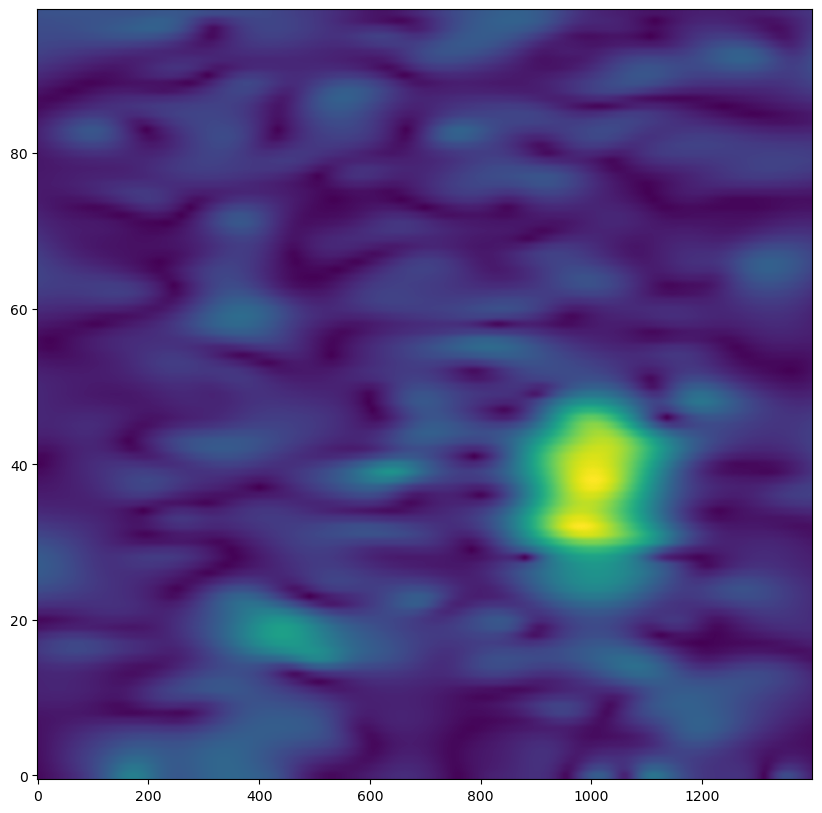

In [10]:
import mne_connectivity

fmin=1
fmax=100
fs=2000
freqs = np.arange(fmin,fmax)
n_cycles = freqs/3

con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_erp, method='coh', sfreq=int(fs),
                                    mode='cwt_morlet', cwt_freqs=freqs,
                                    cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)

coh = con.get_data(output='dense')
indices = con.names
row=[]
aon_vHp_con=[]
for i in range(coh.shape[0]):
    for j in range(coh.shape[1]):
        if 'AON' in indices[j] and 'vHp' in indices[i]:
            coherence= coh[i,j,:,:]
            coherence=np.arctanh(coherence)
            aon_vHp_con.append(coherence)
        row.append(np.mean(aon_vHp_con, axis=0))

fig, ax = plt.subplots(1,1, figsize =(10,10))
ax.imshow(coherence, aspect='auto', origin='lower')

<bound method get_data of <EpochsArray | 10 events (all good), 0 – 0.7 s (baseline off), ~225 KiB, data loaded,
 '1': 10>>


In [ ]:

def baseline_signal(baseline_time_sec, fs):
    signal_len = int(fs*baseline_time_sec)
    baseline_signal = np.random.randn(signal_len)
    return baseline_signal

def epochs_without_erp(number_of_epoch, epoch_time_sec, fs):
    signal_len = int(number_of_epoch*epoch_time_sec*fs)
    epochs_without_erp = np.random.randn(signal_len)
    return epochs_without_erp


def base_signal_generation(baseline_time_sec, epoch_time_sec, number_of_epoch, fs):
    # Ensure signal length accommodates complete epochs
    signal_len = int(fs * baseline_time_sec + number_of_epoch * epoch_time_sec * fs)
    base_signal = np.random.randn(signal_len)
    time = np.arange(0, signal_len) / fs  # More precise time array
    return base_signal, time

def generate_sin_wave(start_time, end_time, frequency_list, amplitude, fs, theta):
    time = np.arange(start_time, end_time, 1/fs)
    sin_combined = np.zeros_like(time)
    for freq in frequency_list:
        sinewave = amplitude * np.sin(2 * np.pi * freq * time + theta)
        sin_combined = sin_combined + sinewave
    return sin_combined


def add_erp_to_epochs(signal, baseline_time_sec, epoch_time_sec, fs, 
                      erp_start_sec, erp_end_sec, frequency_list, 
                      amplitude=1, theta=0, epoch_indices=None):
    """
    Add ERP (sine wave) to specific epochs at a defined time window.
    
    Parameters:
    -----------
    signal : ndarray
        The base signal to modify
    baseline_time_sec : float
        Duration of baseline in seconds
    epoch_time_sec : float
        Duration of each epoch in seconds
    fs : int
        Sampling frequency
    erp_start_sec : float
        Start time of ERP within each epoch (relative to epoch start)
    erp_end_sec : float
        End time of ERP within each epoch (relative to epoch start)
    frequency_list : list
        List of frequencies to include in the sine wave
    amplitude : float
        Amplitude of the sine wave
    theta : float
        Phase offset
    epoch_indices : list or None
        Specific epoch indices to add ERP to. If None, adds to all epochs.
    
    Returns:
    --------
    signal : ndarray
        Modified signal with ERPs added
    """
    # Generate the ERP signal
    erp_signal = generate_sin_wave(start_time=erp_start_sec, end_time=erp_end_sec,
                                    frequency_list=frequency_list, amplitude=amplitude,
                                    fs=fs, theta=theta)
    erp_len = len(erp_signal)
    
    # Calculate epoch start positions
    signal_len = len(signal)
    epoch_starts = np.arange(int(baseline_time_sec*fs), signal_len, int(fs*epoch_time_sec))
    
    # If specific epochs are requested, filter the epoch starts
    if epoch_indices is not None:
        epoch_starts = epoch_starts[epoch_indices]
    
    # Add ERP to each epoch
    for epoch_start in epoch_starts:
        # Calculate absolute position in signal
        erp_start_index = epoch_start + int(erp_start_sec * fs)
        erp_end_index = erp_start_index + erp_len
        
        # Check bounds
        if erp_end_index <= len(signal):
            signal[erp_start_index:erp_end_index] += erp_signal
        else:
            print(f"Warning: ERP at index {epoch_start} exceeds signal length")
    
    return signal, 


In [ ]:
baseline_time_sec = 2
epoch_time_sec = 0.7
number_of_epoch = 10
fs=2000

erp_start_sec = 0.4
erp_end_sec = 0.5
frequency_list = [40]


aon_1_bsline = baseline_signal(baseline_time_sec, fs=2000)

aon_1_base_sig = epochs_without_erp(number_of_epoch=number_of_epoch, epoch_time_sec=epoch_time_sec, fs=fs)

aon_1_erp = add_erp_to_epochs(aon_1_base_sig, baseline_time_sec=baseline_time_sec, epoch_time_sec=epoch_time_sec, fs=fs, erp_start_sec=0.4, erp_end_sec=0.5, frequency_list=[40])


plt.plot(aon_1_erp)

In [ ]:


baseline_time_sec = 2
epoch_time_sec = 0.7
number_of_epoch = 10
fs = 2000
signal_len = fs*baseline_time_sec + fs*epoch_time_sec*number_of_epoch

aon_1, t1 = base_signal_generation(baseline_time_sec=baseline_time_sec, epoch_time_sec=epoch_time_sec, 
                                     number_of_epoch=number_of_epoch, fs=fs)
vhp_1, t2 = base_signal_generation(baseline_time_sec=baseline_time_sec, epoch_time_sec=epoch_time_sec, 
                                     number_of_epoch=number_of_epoch, fs=fs)

sin_start_sec = 0.4
sin_end_sec = 0.5
frequency_list = [40]
theta = 0
amplitude = 1

sin_combined = generate_sin_wave(start_time=sin_start_sec, end_time=sin_end_sec, 
                                  frequency_list=frequency_list, amplitude=amplitude, fs=fs, theta=theta)
print(f"sin_combined length: {len(sin_combined)}")

epoch_times = np.arange(int(baseline_time_sec*fs), int(signal_len), int(fs*epoch_time_sec))
print(epoch_times)

# Use the length of sin_combined to determine the end index
sin_len = len(sin_combined)

for epochi in epoch_times:
    erp_start_index = epochi
    erp_end_index = epochi + sin_len  # Use actual length instead of calculation
    print(erp_start_index, erp_end_index)
    
    aon_1[erp_start_index:erp_end_index] = aon_1[erp_start_index:erp_end_index] + sin_combined
    vhp_1[erp_start_index:erp_end_index] = vhp_1[erp_start_index:erp_end_index] + sin_combined

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(t1, aon_1, label="aon")
axs.plot(t2, vhp_1, label="vhp")
axs.legend()
plt.show()

## Generating Artificial ERP data and plotting it

### For simplicity, I will generate 2 channels of data with 10 epochs of 700ms each. The data will begin with 2seconds of baseline data that will contain just noise. 

### Combining sine waves with the base_signal

## Power Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_connectivity


# ============= SIGNAL GENERATION FUNCTIONS =============

def generate_base_signal(baseline_time_sec, epoch_time_sec, number_of_epoch, fs):
    """Generate a continuous signal with baseline + epochs filled with noise."""
    signal_len = int(fs * baseline_time_sec + number_of_epoch * epoch_time_sec * fs)
    signal = np.random.randn(signal_len)
    time = np.arange(signal_len) / fs
    return signal, time


def generate_sine_wave(start_time, end_time, frequency_list, amplitude, fs, phase=0):
    """Generate a sine wave with specified frequencies."""
    time = np.arange(start_time, end_time, 1/fs)
    sine_wave = np.zeros_like(time)
    for freq in frequency_list:
        sine_wave += amplitude * np.sin(2 * np.pi * freq * time + phase)
    return sine_wave


def add_erp_to_signal(signal, baseline_time_sec, epoch_time_sec, fs, 
                      erp_start_sec, erp_end_sec, frequency_list, 
                      amplitude=1, phase=0, epoch_indices=None):
    """
    Add ERP (sine wave) to specific epochs at a defined time window.
    
    Parameters:
    -----------
    signal : ndarray
        The base signal to modify (will be modified in place)
    baseline_time_sec : float
        Duration of baseline in seconds
    epoch_time_sec : float
        Duration of each epoch in seconds
    fs : int
        Sampling frequency
    erp_start_sec : float
        Start time of ERP within each epoch (relative to epoch start)
    erp_end_sec : float
        End time of ERP within each epoch (relative to epoch start)
    frequency_list : list
        List of frequencies to include in the sine wave
    amplitude : float
        Amplitude of the sine wave (default: 1)
    phase : float
        Phase offset in radians (default: 0)
    epoch_indices : list or None
        Specific epoch indices to add ERP to. If None, adds to all epochs.
    
    Returns:
    --------
    signal : ndarray
        Modified signal with ERPs added
    """
    # Generate the ERP signal
    erp_signal = generate_sine_wave(erp_start_sec, erp_end_sec, frequency_list, amplitude, fs, phase)
    erp_len = len(erp_signal)
    
    # Calculate all epoch start positions in the signal
    signal_len = len(signal)
    all_epoch_starts = np.arange(int(baseline_time_sec * fs), signal_len, int(fs * epoch_time_sec))
    
    # Filter to specific epochs if requested
    if epoch_indices is not None:
        epoch_starts = all_epoch_starts[epoch_indices]
    else:
        epoch_starts = all_epoch_starts
    
    # Add ERP to each selected epoch
    for epoch_start in epoch_starts:
        erp_start_idx = epoch_start + int(erp_start_sec * fs)
        erp_end_idx = erp_start_idx + erp_len
        
        if erp_end_idx <= len(signal):
            signal[erp_start_idx:erp_end_idx] += erp_signal
        else:
            print(f"Warning: ERP extends beyond signal length at index {epoch_start}")
    
    return signal


# ============= MNE CONVERSION FUNCTION =============

def create_mne_epochs(signals_dict, baseline_time_sec, epoch_time_sec, fs):
    """
    Convert continuous signals to MNE Epochs format.
    
    Parameters:
    -----------
    signals_dict : dict
        Dictionary with channel names as keys and signals as values
        Example: {'AON_1': signal1, 'vHp_1': signal2}
    baseline_time_sec : float
        Duration of baseline in seconds
    epoch_time_sec : float
        Duration of each epoch in seconds
    fs : int
        Sampling frequency
    
    Returns:
    --------
    mne_epochs : mne.EpochsArray
        MNE Epochs object
    """
    channel_names = list(signals_dict.keys())
    n_channels = len(channel_names)
    
    # Get signal length and calculate epochs
    first_signal = list(signals_dict.values())[0]
    signal_len = len(first_signal)
    epoch_starts = np.arange(int(baseline_time_sec * fs), signal_len, int(fs * epoch_time_sec))
    n_epochs = len(epoch_starts)
    epoch_len = int(epoch_time_sec * fs)
    
    # Create empty array for epochs
    epoch_data = np.zeros((n_epochs, n_channels, epoch_len))
    
    # Fill with data from each channel
    for ch_idx, ch_name in enumerate(channel_names):
        signal = signals_dict[ch_name]
        for epoch_idx, epoch_start in enumerate(epoch_starts):
            epoch_end = epoch_start + epoch_len
            if epoch_end <= len(signal):
                epoch_data[epoch_idx, ch_idx, :] = signal[epoch_start:epoch_end]
    
    # Create MNE info and epochs
    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    mne_epochs = mne.EpochsArray(epoch_data, info)
    
    return mne_epochs


# ============= ANALYSIS FUNCTIONS =============

def compute_power_tfr(epochs, fmin=2.5, fmax=100):
    """Compute time-frequency power using Morlet wavelets."""
    freqs = np.arange(fmin, fmax)
    n_cycles = freqs / 3
    
    power = epochs.compute_tfr(
        method="morlet", 
        freqs=freqs, 
        n_cycles=n_cycles, 
        return_itc=False, 
        average=False
    )
    return power


def compute_coherence(epochs, fmin=1, fmax=100):
    """Compute spectral coherence between channels."""
    fs = epochs.info['sfreq']
    freqs = np.arange(fmin, fmax)
    n_cycles = freqs / 3
    
    con = mne_connectivity.spectral_connectivity_epochs(
        epochs, 
        method='coh', 
        sfreq=int(fs),
        mode='cwt_morlet', 
        cwt_freqs=freqs,
        cwt_n_cycles=n_cycles, 
        verbose=False, 
        fmin=fmin, 
        fmax=fmax, 
        faverage=False
    )
    
    return con


# ============= EXAMPLE USAGE =============

# Parameters
baseline_time_sec = 2
epoch_time_sec = 0.7
number_of_epoch = 10
fs = 2000

# Generate base signals for two channels
aon_1, time = generate_base_signal(baseline_time_sec, epoch_time_sec, number_of_epoch, fs)
vhp_1, _ = generate_base_signal(baseline_time_sec, epoch_time_sec, number_of_epoch, fs)

# Add ERPs to signals
# Example 1: Add 40 Hz ERP from 0.4-0.5s to all epochs
aon_1 = add_erp_to_signal(
    signal=aon_1,
    baseline_time_sec=baseline_time_sec,
    epoch_time_sec=epoch_time_sec,
    fs=fs,
    erp_start_sec=0.4,
    erp_end_sec=0.5,
    frequency_list=[40],
    amplitude=2
)

# Example 2: Add 40 Hz ERP only to even epochs (0, 2, 4, 6, 8)
vhp_1 = add_erp_to_signal(
    signal=vhp_1,
    baseline_time_sec=baseline_time_sec,
    epoch_time_sec=epoch_time_sec,
    fs=fs,
    erp_start_sec=0.4,
    erp_end_sec=0.5,
    frequency_list=[40],
    amplitude=2,
)

# Plot continuous signals
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
axs[0].plot(time, aon_1, label="AON_1 (ERP in all epochs)")
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(time, vhp_1, label="vHp_1 (ERP in even epochs)", color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Convert to MNE Epochs
signals_dict = {'AON_1': aon_1, 'vHp_1': vhp_1}
mne_epochs = create_mne_epochs(signals_dict, baseline_time_sec, epoch_time_sec, fs)
print(f"\nMNE Epochs created: {mne_epochs}")
print(f"Shape: {mne_epochs.get_data().shape}")  # (n_epochs, n_channels, n_times)

# Power analysis
print("\nComputing power...")
aon_power = compute_power_tfr(mne_epochs.copy().pick('AON_1'))
averaged_power = aon_power.average()
averaged_power.plot(title="AON_1 Power", combine='mean', vlim=(0, None))
plt.show()

# Coherence analysis
print("\nComputing coherence...")
coherence = compute_coherence(mne_epochs)
coh_data = coherence.get_data(output='dense')

# Extract AON-vHp coherence
indices = coherence.names
for i in range(coh_data.shape[0]):
    for j in range(coh_data.shape[1]):
        if 'AON' in indices[i] and 'vHp' in indices[j]:
            coh_matrix = coh_data[i, j, :, :]
            coh_matrix = np.arctanh(coh_matrix)  # Fisher z-transform
            
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
            im = ax.imshow(coh_matrix, aspect='auto', origin='lower', cmap='viridis')
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title('AON-vHp Coherence')
            plt.colorbar(im, ax=ax, label='Coherence (z-transformed)')
            plt.show()

print("\nDone!")